In [1]:
using PyPlot
versioninfo()

Julia Version 0.6.2
Commit d386e40c17* (2017-12-13 18:08 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


# Overview

[Numerical Continuation](https://en.wikipedia.org/wiki/Numerical_continuation) is a set of methods to calculate approximate solutions to equations of the form

$$ F(\mathbf{u}) = 0 \quad F: \mathbb{R}^{N+1} \rightarrow \mathbb{R}^{N} $$

Applications of continuation methods range from dynamical systems to homotopy methods for polynomials (for the latter, the Julia package [HomotopyContinuation.jl](http://pkg.julialang.org/detail/HomotopyContinuation) exists). The state-of-the-art software for numerical continuation is the Fortran package [AUTO](https://sourceforge.net/projects/auto-07p/) and the python package [PyCont](http://www2.gsu.edu/~matrhc/PyCont.html).

This notebook includes a rudimentary implementation of the traditional predictor-corrector continuation method. Compared to more sophisticated methods in AUTO and PyCont, what our method lacks is the ability to adapt the step length and numerically approximate the Jacobian of $F$. The interface for the methods are in part inspired by [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/index.html).

For an in-depth review of different numerical continuation methods, you can refer to the book: Allgower, Eugene L., and Kurt Georg. Introduction to numerical continuation methods. Vol. 45. SIAM, 2003.

# 1. Continuation as an initial value problem

One crucial characteristic of $F(\mathbf{u})$ is that its roots are essentially one-dimensional, since we have $N+1$ unkowns and $N$ equations. To be more precise: if the Jacobian $F'(\mathbf{u}^*)$ has full rank, then locally the solutions to $F(\mathbf{u}) = 0$ can be represented as a smooth curve $\mathbf{u}(s)$ which satisfies

$$ \mathbf{u}(0) = \mathbf{u}^*, \quad F(\mathbf{u}(s)) = 0, \quad F'(\mathbf{u}(s))\mathbf{u}'(s) = \mathbf{0} $$

In other words, the tangent vector $\mathbf{u}'(s)$ is in the null space of the Jacobian $F'(\mathbf{u}(s))$ (which by our assumption has dimension 1). This gives us a way of computing the tangent vector from the Jacobian (say via QR factorization). Of course there's still the question of the magnitude and direction of $\mathbf{u}'(s)$. We can always set the magnitude to 1 (this corresponds to using an arclength parametrization), while for the direction we can orient $\mathbf{u}'(s)$ such that 

$$ \det\begin{pmatrix} F' \\ \mathbf{u}'^T \end{pmatrix} $$

is always positive(negative). This corresponds to the positive(negative) orientation used in differential geometry.

With the above in mind, we can now define a function $t(\mathbf{u})$ that uniquely computes a tangent vector at each point $\mathbf{u}$ using the Jacobian $F'(\mathbf{u})$. The equation for the curve becomes

$$ \dot{\mathbf{u}} = t(\mathbf{u}),\quad\mathbf{u}(0) = \mathbf{u}^* $$

This means that, once we have computed one solution $\mathbf{u}^*$ to the equation, we can use it as the initial value and compute all other solutions by solving an ODE (as long as the smoothness and regularity condition for $F$ holds). This is where "continuation" gets its name from. Of course for open curves we need at least two runs with different orientation to get all results, but that's just a technicality. 

# 2. The Euler-Newton predictor-corrector algorithm

A naive solution to the initial value problem would be using the Forward Euler method:

$$ \mathbf{u}_{n+1} = \mathbf{u}_n + ht(\mathbf{u}) $$

where $h > 0$ is the step length. The problem for this, however, is that we will gradually drift away from the solution curve. To improve this, we can add a "corrector" step to the computed next point (the "predictor result" in continuation jargon) that brings the point closer to the solution curve. The classical corrector method is the Newton method: for a point $\mathbf{v}_k$ close to the solution, one step of Newton corrector yields

$$ \mathbf{v}_{k+1} = \mathbf{v}_k - F'(\mathbf{v}_k)^+F(\mathbf{v}_k) $$

and we typically repeat the iteration until a convergence criteria regarding the residual $\|F(\mathbf{v}_{k})\|$ is met. Note that we use the Moore-Penrose pseudoinverse $F'(\mathbf{v}_k)^+$ because $F'$ is no longer square as in the classical Newton's method. (We don't actually need to calculate the pseudoinverse because only its application on a vector is desired. In julia this can be achieved using the backslash `\` operator).

The Euler-Newton predictor-corrector continuation method simply combines a Euler step predictor and Newton corrector. Our Julia implementation of the algorithm is as follows:

In [2]:
abstract type AbstractTracer end

mutable struct Tracer <: AbstractTracer
    F! # F!(Fu, Ju, u) computes F and its Jacobian in-place

    # The "state" of the tracer (where it is currently at)
    u::Vector{Float64}
    Fu::Vector{Float64}
    Ju::Matrix{Float64}

    # Options and parameters
    stepsize::Float64 # step size for the predictor
    tol::Float64 # tolerance for the corrector
    direction::Int # +1/-1 for positive/negative orientation
end

"""
    Tracer(F!, u0; kwargs...) -> t

Constructor for `Tracer` given the function `F!` and initial guess `u0`.

`F!` has the signature `F!(Fu, Ju, u)`, which computes the value of the function `Fu` and its 
 Jacobian `Ju` at point `u` in place. `u0` should be moderately close to the solution curve but 
 in general need not satisfy the residual tolerance. 

Keyword arguments:

* stepsize (default: 0.01): the fixed step size used in the predictor step.

* tol (default: 1e-6): the tolerance in residual used in the corrector step.

* direction (default: 1): the direction in which the tracer moves. Can be +1 or -1.
"""
function Tracer(F!, u0::Vector{Float64}; stepsize=0.2, tol=1e-6, direction=1)
    @assert stepsize > 0
    @assert tol > 0
    @assert direction in (1, -1)
    
    # Compute Fu and Ju for initial guess
    N = length(u0) - 1
    u = u0[:] # make sure to copy
    Fu = Vector{Float64}(N)
    Ju = Matrix{Float64}(N, N+1)
    F!(Fu, Ju, u)
    t = Tracer(F!, u, Fu, Ju, stepsize, tol, direction)
    
    # Perform a corrector step to have an initial point within residual tolerance
    correct!(t)
    return t
end

"""
    move!(t, du)

Advance the tracer by displacement `du` and recomputes `t.Fu` and `t.Ju`.
"""
function move!(t::Tracer, du::Vector{Float64})
    t.u .+= du
    t.F!(t.Fu, t.Ju, t.u)
end

"""
    predict!(t)

Performs a prediction step and advance the tracer to the predicted point.
"""
function predict!(t::Tracer)
    # Compute the tangent vector using QR factorization
    # TODO: determine how exactly Julia computes QR (in particular, what is det(Q))
    N = length(t.u) - 1
    fact = qrfact(t.Ju')
    tvec = fact[:Q][:,end] # tvec is a unit tangent vector
    # Point tvec to the correct orientation
    if (-1)^N * prod(diag(fact[:R])) > 0
        tvec *= t.direction
    else
        tvec *= -t.direction
    end
    move!(t, t.stepsize * tvec)
end

"""
    correct!(t) -> niter

Performs a correction step and returns the number of Newton iterations.

Also used in initialization to obtain the starting point. The output is discarded in this notebook, 
 but it is an important metric used in step size adaptation.
"""
function correct!(t::Tracer)
    niter = 0
    while norm(t.Fu) > t.tol
        move!(t, -t.Ju \ t.Fu) # Newton update
        niter += 1
    end
    return niter
end

step!(t::Tracer) = (predict!(t); correct!(t)) # one predictor-corrector step
;

The `predict!`, `correct!` and `step!` methods should be pretty self-explainatory. Note that we implemented `Tracer` in a way to use in-place operations as much as possible to save time. Before we test our implementation, let's write a wrapper function to streamline the gathering of results and plotting:

In [3]:
function trace_and_plot(tracer::AbstractTracer, Nstep::Int)
    trajectory = zeros(2,Nstep+1); trajectory[:,1] = tracer.u
    for step = 1:Nstep
        step!(tracer)
        trajectory[:,step+1] = tracer.u
    end

    figure()
    plot(trajectory[1,:], trajectory[2,:], ":")
    scatter(trajectory[1,:], trajectory[2,:], c=1:Nstep+1)
    xlabel("x")
    ylabel("y")
    axis("equal")
end
;

Let's first start with a simple example: the parabola. The standard form of a parabola is 

$$ y^2 = 2px $$

In [4]:
struct Parabola
    # y^2 = 2px
    p::Float64
end

function (c::Parabola)(Fu, Ju, u)
    Fu[1] = 2 * c.p * u[1] - u[2]^2
    Ju[1,1] = 2 * c.p
    Ju[1,2] = -2 * u[2]
end
;

Note how we wrote the functor `Parabola` to have the same signature as the `F!` paremeter for `Tracer`. Let's see how our algorithm fares:

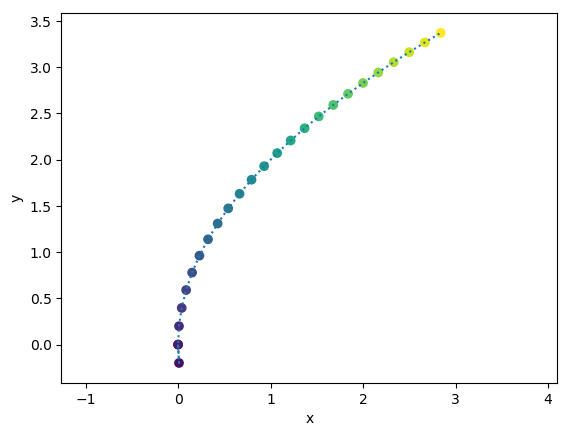

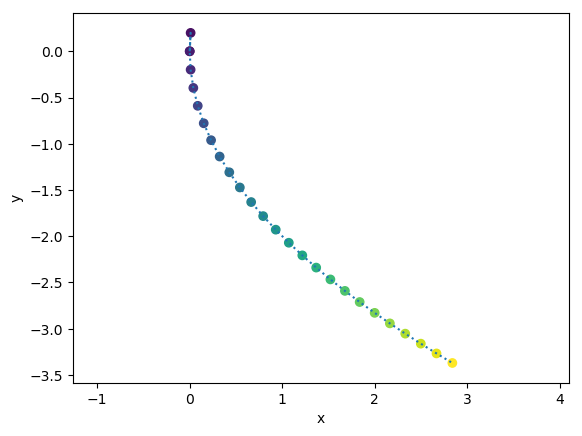

In [5]:
curve = Parabola(2.0)
u0 = [0.0, 0.0]
tracer_positive = Tracer(curve, u0)
tracer_negative = Tracer(curve, u0; direction=-1)
trace_and_plot(tracer_positive, 25)
trace_and_plot(tracer_negative, 25)
;

The scatter plot is colored blue to yellow to show the sequencing of the points. As expected, two runs with different orientation combine to form the solution. 

Let's try a lightly more complex problem, the [Cissoid of Diocles](http://mathworld.wolfram.com/CissoidofDiocles.html). Although the curve in question has a cusp singularity, the Euler-Newton continuation is still able to resolve the solution curve:

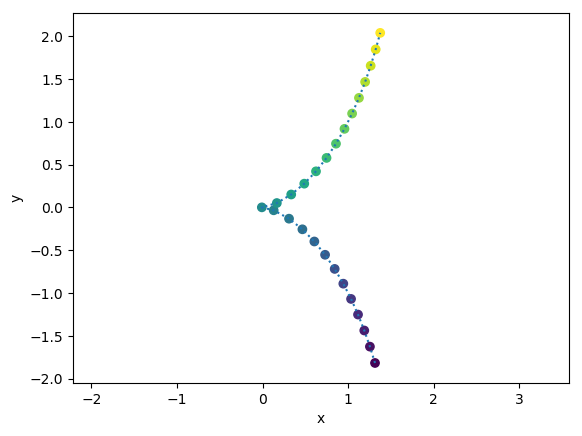

In [6]:
struct DioclesCissoid
    # x(x^2 + y^2) = 2ay^2
    a::Float64
end

function (c::DioclesCissoid)(Fu, Ju, u)
    x = u[1]; y = u[2]
    Fu[1] = x^3 + x * y^2 - 2 * c.a * y^2
    Ju[1] = 3 * x^2 + y^2
    Ju[2] = 2 * (x - 2 * c.a) * y
end

curve = DioclesCissoid(1.0)
u0 = [1.0, -2.0]
tracer = Tracer(curve, u0)
trace_and_plot(tracer, 25)
;

# 3. Bifurcation Detection

Our naive implementation fails if a **bifurcation point** is present on the solution curve. Simply put, at a bifurcation point $\mathbf{u}^*$ the Jacobian $F'(\mathbf{u}^*)$ doesn't has full rank, thus making the assumption that the solution behaves locally as a curve fail.

To see the effect of bifurcation, consider the [Maclaurin Trisectrix](http://mathworld.wolfram.com/MaclaurinTrisectrix.html), which has a knot-like structure. The crossing point $(0,0)^T$ is an example of bifurcation points (it is in fact a **simple bifurcation point**, which is characterized by the fact that $dim(Ker(F')) = 2$). As we shall see below, our naive implementation gets "stuck" at the bifurcation point:

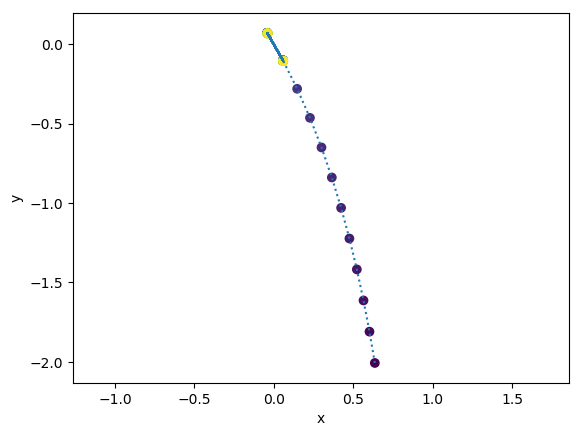

In [7]:
struct MaclaurinTrisectrix
    # y^2(a - x) = x^2(x + 3a)
    a::Float64
end

function (c::MaclaurinTrisectrix)(Fu, Ju, u)
    x = u[1]; y = u[2]
    Fu[1] = x^3 + x * y^2 + 3 * c.a * x^2 - c.a * y^2
    Ju[1,1] = 3 * x^2 + y^2 + 6 * c.a * x
    Ju[1,2] = 2 * x * y - 2 * c.a * y
end

curve = MaclaurinTrisectrix(1.0)
u0 = [1.0, -2.0]
tracer = Tracer(curve, u0)
trace_and_plot(tracer, 60)
;

We can modify our algorithm to encompass simple bifurcation points using the following fact: across a bifurcation point the orientation of solution curves change signs (see *Allgower and Kurt* for the math behind this). The `BifurcationTracer` stores the tangent vector computed in each step and compares it against the current tangent vector to determine if a reverse of direction has happened. If so, the tracer reports the presence of a bifurcation point, switches the transversal direction and continues the Euler-Newton steps.

Most of the code below is the same as `Tracer`. Note that the computation of tangent vectors has been moved from the start of `predict!` to then end of `correct!` to better suit the program logic.

TODO: restructure the code to favor more code reuse.

In [8]:
mutable struct BifurcationTracer <: AbstractTracer
    F! # F!(Fu, Ju, u) computes F and its Jacobian in-place

    # The "state" of the tracer (where it is currently at)
    u::Vector{Float64}
    Fu::Vector{Float64}
    Ju::Matrix{Float64}

    # We need to store the previous tangent vector to detect bifurcation
    tvec::Vector{Float64}

    # Options and parameters
    stepsize::Float64 # step size for the predictor
    tol::Float64 # tolerance for the corrector
    direction::Int # +1/-1 for positive/negative orientation
end

"""
    BifurcationTracer(F!, u0; kwargs...) -> t

Constructor for `BifurcationTracer` given the function `F!` and initial guess `u0`.

`F!` has the signature `F!(Fu, Ju, u)`, which computes the value of the function `Fu` and its 
 Jacobian `Ju` at point `u` in place. `u0` should be moderately close to the solution curve but 
 in general need not satisfy the residual tolerance. 

Keyword arguments:

* stepsize (default: 0.01): the fixed step size used in the predictor step.

* tol (default: 1e-6): the tolerance in residual used in the corrector step.

* direction (default: 1): the direction in which the tracer moves. Can be +1 or -1.
"""
function BifurcationTracer(F!, u0::Vector{Float64}; stepsize=0.2, tol=1e-6, direction=1)
    @assert stepsize > 0
    @assert tol > 0
    @assert direction in (1, -1)
    
    # Compute Fu and Ju for initial guess
    N = length(u0) - 1
    u = u0[:] # make sure to copy
    Fu = Vector{Float64}(N)
    Ju = Matrix{Float64}(N, N+1)
    F!(Fu, Ju, u)
    tvec = zeros(N+1)
    t = BifurcationTracer(F!, u, Fu, Ju, tvec, stepsize, tol, direction)
    
    # Perform a corrector step to have an initial point within residual tolerance
    correct!(t)
    return t
end

"""
    move!(t, du)

Advance the tracer by displacement `du` and recomputes `t.Fu` and `t.Ju`.
"""
function move!(t::BifurcationTracer, du::Vector{Float64})
    t.u .+= du
    t.F!(t.Fu, t.Ju, t.u)
end

"""
    predict!(t)

Performs a prediction step and advance the tracer to the predicted point.
"""
function predict!(t::BifurcationTracer)
    move!(t, t.stepsize * t.tvec)
end

"""
    correct!(t) -> niter

Performs a correction step and returns the number of Newton iterations.

Also used in initialization to obtain the starting point. The output is discarded in this notebook, 
 but it is an important metric used in step size adaptation.
"""
function correct!(t::BifurcationTracer)
    niter = 0
    while norm(t.Fu) > t.tol
        move!(t, -t.Ju \ t.Fu) # Newton update
        niter += 1
    end
    
    # Compute the tangent vector using QR factorization
    N = length(t.u) - 1
    fact = qrfact(t.Ju')
    tvec = fact[:Q][:,end] # tvec is a unit tangent vector
    # Point tvec to the correct orientation
    if (-1)^N * prod(diag(fact[:R])) > 0
        tvec *= t.direction
    else
        tvec *= -t.direction
    end
    
    # Compare tvec to the previous tangent vector to determine if bifurcation is encountered
    # Note that since t.tvec is initialized to all zero, the condition will always fail when
    #  correct! is invoked in the constructor.
    if tvec' * t.tvec < 0
        println("Bifurcation point encountered around ", t.u)
        # Revert the transversal direction
        t.direction = -t.direction
        t.tvec = -tvec
    else
        t.tvec = tvec
    end
    return niter
end

step!(t::BifurcationTracer) = (predict!(t); correct!(t)) # one predictor-corrector step
;

The improved method can now pass the bifurcation point and continue transversing the trisectrix:

Bifurcation point encountered around 

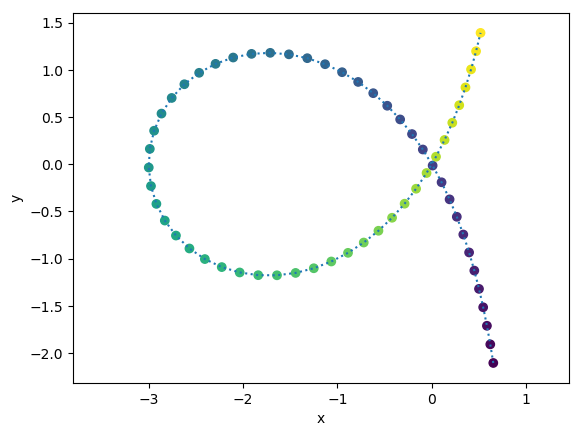

[-0.0956226, 0.155688]
Bifurcation point encountered around [0.0441882, 0.078859]


In [9]:
curve = MaclaurinTrisectrix(1.0)
u0 = [1.0, -2.1]
tracer = BifurcationTracer(curve, u0)
trace_and_plot(tracer, 60)
;

One caveat is that our implementation of `BifurcationTracer` does not guarantee which branch the tracer will jump to after encountering a bifurcation point (you can observe this by slightly tweaking `u0` above). Production quality code spend much more effort around bifurcation detection due to its inherent complexity